# Extract Parameters

Process the synthetic files and extract equivalent circuit model parameters

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

sys.path.append('../')

from src import fit as fit
from src import plotter as plotter
plotter.initialize(plt)

## Open Circuit Voltage

Use the pseudo-OCV test to extract the OCV curve and the nominal (OCV) cell capacity

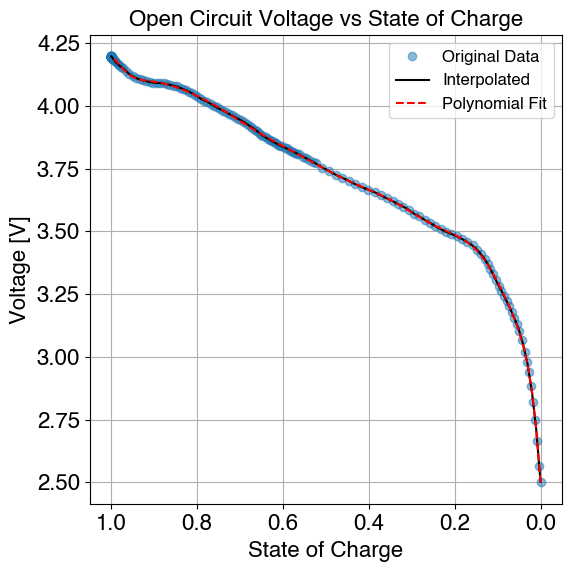

In [27]:
df = pd.read_csv('../output/synthetic_data/characterization_test_ocv_0.01C.csv')

soc = 1 - df['Capacity [Ah]']/df['Capacity [Ah]'].max()
voltage = df['Voltage [V]']

# Flip the vectors so that they start at 0% SOC
soc = soc[::-1]
voltage = voltage[::-1]

# Create evenly spaced SOC points for interpolation
# First remove any duplicate SOC values to ensure monotonic interpolation
soc_interp = np.linspace(0, 1, 100)
voltage_interp = np.interp(soc_interp, soc, voltage)

# Fit a polynomial
poly_order = 15
coef_fit = np.polyfit(soc_interp, voltage_interp, poly_order)
voltage_fit = np.polyval(coef_fit, soc_interp)

# Save interpolated data to CSV
ocv_data = pd.DataFrame({
    'SOC': soc_interp,
    'Voltage [V]': voltage_interp
})
ocv_data.to_csv('../output/parameters/ocv_lookup.csv', index=False)

# Save the polynomial coefficients
coef_df = pd.DataFrame({
    'order': range(len(coef_fit)-1, -1, -1),
    'coefficient': coef_fit
})
coef_df.to_csv('../output/parameters/ocv_poly_coefficients.csv', index=False)

# Create a dataframe with the capacity value
capacity_df = pd.DataFrame({
    'Capacity [Ah]': [df['Capacity [Ah]'].max()]
})
capacity_df.to_csv('../output/parameters/ocv_capacity.csv', index=False)

# Define a lookup function that maps voltage to SOC and vice versa
lookup_ocv_to_soc = lambda v: np.interp(v, voltage_interp, soc_interp)
lookup_soc_to_ocv = lambda s: np.interp(s, soc_interp, voltage_interp)

# Plot original and interpolated data
plt.figure()
plt.plot(soc, voltage, 'o', alpha=0.5, label='Original Data')
plt.plot(soc_interp, voltage_interp, 'k-', label='Interpolated')
plt.plot(soc_interp, voltage_fit, 'r--', label='Polynomial Fit')
plt.gca().invert_xaxis()
plt.xlabel('State of Charge')
plt.ylabel('Voltage [V]')
plt.grid(True)
plt.legend(fontsize=12)
plt.title('Open Circuit Voltage vs State of Charge')

plt.tight_layout()
plt.savefig('../output/figs/ocv_interpolated.png', dpi=150)

## Process the HPPC data

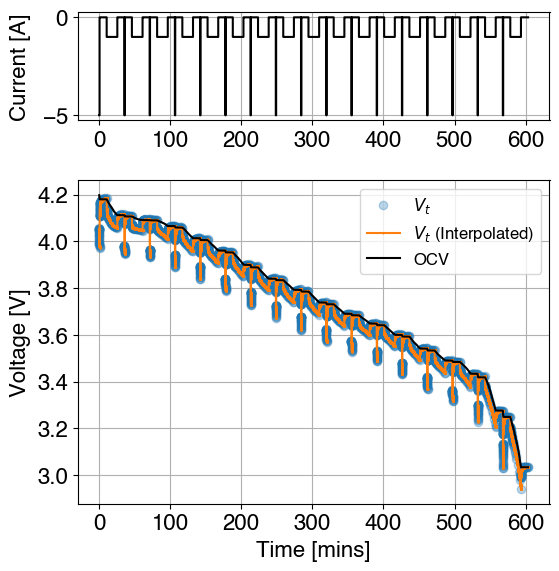

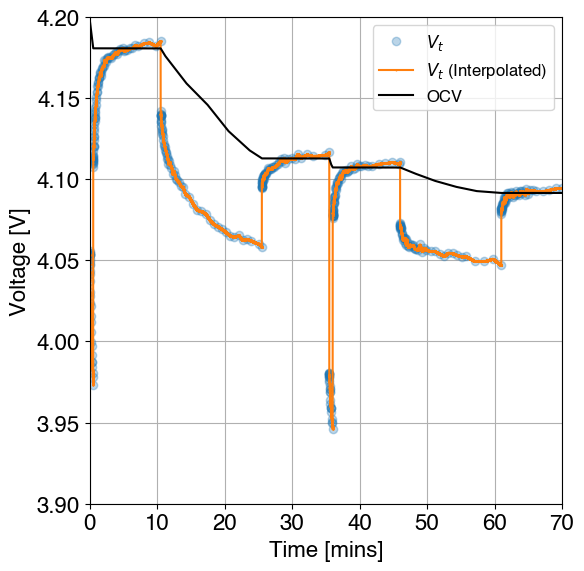

In [28]:
df = pd.read_csv('../output/synthetic_data/characterization_test_hppc_1.0C.csv')

df['SOC'] = 1 - df['Capacity [Ah]']/df['Capacity [Ah]'].max()

# Get the last voltage measurement and find corresponding SOC
final_voltage = df['Voltage [V]'].iloc[-1]
final_soc = lookup_ocv_to_soc(final_voltage)

# Scale SOC to span between final_soc and 1
df['SOC'] = final_soc + (1 - final_soc) * df['SOC']

# Sample the data along an evenly spaced time vector
dt = 0.1
time_s2 = np.arange(0, df['Time [s]'].max() + dt, dt)
voltage_interp2 = np.interp(time_s2, df['Time [s]'], df['Voltage [V]'])
current_interp2 = np.interp(time_s2, df['Time [s]'], df['Current [A]'])
power_interp2 = np.interp(time_s2, df['Time [s]'], df['Power [W]'])
capacity_interp2 = np.interp(time_s2, df['Time [s]'], df['Capacity [Ah]'])
energy_interp2 = np.interp(time_s2, df['Time [s]'], df['Energy [Wh]'])
soc_interp2 = np.interp(time_s2, df['Time [s]'], df['SOC'])
ocv_interp2 = lookup_soc_to_ocv(soc_interp2)

# Create a new dataframe with interpolated values
df_interp = pd.DataFrame({
    'Time [s]': time_s2,
    'Current [A]': current_interp2,
    'Power [W]': power_interp2,
    'Voltage [V]': voltage_interp2,
    'Capacity [Ah]': capacity_interp2,
    'Energy [Wh]': energy_interp2,
    'SOC': soc_interp2,
    'OCV [V]': ocv_interp2
})

# Plot original vs interpolated data
fig, (ax1, ax2) = plt.subplots(2, 1,
                               figsize=(6,6),
                               height_ratios=[1, 3])
plt.subplots_adjust(hspace=0.3)

# Plot current vs time
ax1.plot(df['Time [s]']/60, -df['Current [A]'], c='k')
ax1.set_ylabel('Current [A]')

# Plot voltage data
ax2.plot(df['Time [s]']/60, df['Voltage [V]'], 'o', alpha=0.3, label=r'$V_t$')
ax2.plot(time_s2/60, voltage_interp2, 'o-', markersize=0.4, label=r'$V_t$ (Interpolated)')
ax2.plot(time_s2/60, ocv_interp2, '-', markersize=0.4, c='k', label=r'OCV')
ax2.set_xlabel('Time [mins]')
ax2.set_ylabel('Voltage [V]')
ax2.legend(fontsize=12)

fig.align_ylabels([ax1, ax2])
plt.tight_layout()
plt.savefig('../output/figs/hppc_interpolation_1.png', dpi=150)

# Create a zoomed plot for the first 30 minutes
plt.figure()
plt.plot(df['Time [s]']/60, df['Voltage [V]'], 'o', alpha=0.3, label=r'$V_t$')
plt.plot(time_s2/60, voltage_interp2, 'o-', markersize=0.4, label=r'$V_t$ (Interpolated)')
plt.plot(time_s2/60, ocv_interp2, '-', markersize=0.4, c='k', label=r'OCV')
plt.xlabel('Time [mins]')
plt.ylabel('Voltage [V]')
plt.grid(True)
plt.legend(fontsize=12)
plt.xlim(0, 70)
plt.ylim((3.9, 4.2))

plt.tight_layout()
plt.savefig('../output/figs/hppc_interpolation_2.png', dpi=150)

# Use the simple method to extract Rs

In [36]:
def one_pole_digital_filter(x, alpha):

    y = np.zeros_like(x)

    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = (1 - alpha) * x[i] + alpha * y[i-1]

    return y


## Use Least Squares to extract Rs, R1, and C1

/Users/aweng/code/battery-digital-twin-from-scratch/notebooks/../src/fit.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  C1 = dt / (b0 - a0*b1)
/Users/aweng/code/battery-digital-twin-from-scratch/notebooks/../src/fit.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  R1 = (b0 - a0*b1) / (a0+1)


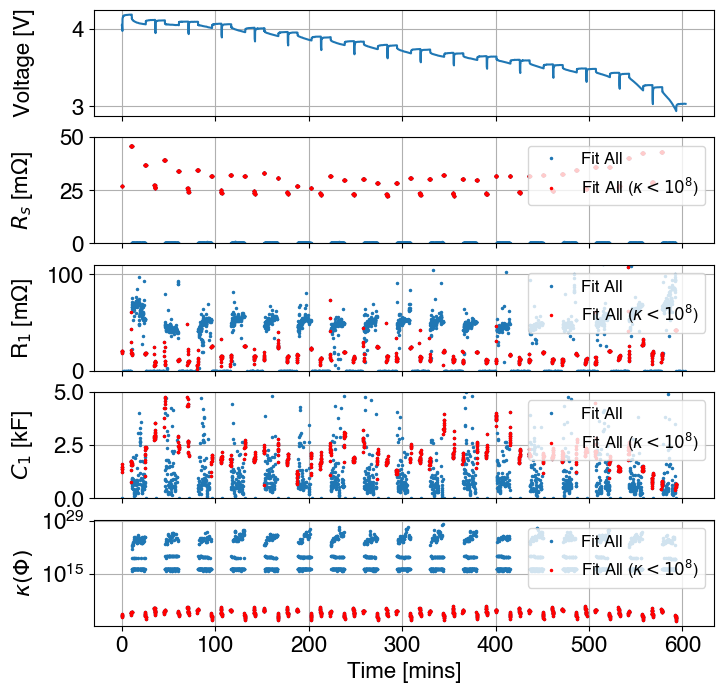

In [29]:
time_horizon_s = 60 # seconds
update_frequency_s = 5 # seconds

# Calculate number of samples in each window
window_samples = int(time_horizon_s / dt)

# Initialize variables specifically for storing parameter estimates
# These variables will have different dimensions based on the update frequency
# and the time horizon
time_params_s = []
soc_param = []
current_param = []

for i in range(len(df_interp)):

    if (i * dt) % update_frequency_s != 0:
        continue

    if i + window_samples > len(df_interp):
        break

    # Get window of data
    voltage_window = df_interp['Voltage [V]'].iloc[i:i+window_samples]
    current_window = df_interp['Current [A]'].iloc[i:i+window_samples]
    ocv_window     = df_interp['OCV [V]'].iloc[i:i+window_samples]

    # Call least squares on the window
    rs, r1, c1, cond_num = fit.least_squares(voltage_window,
                                             -current_window, ocv_window, dt)

    if len(time_params_s) == 0:
        params_mat = np.array([rs, r1, c1, cond_num])
    else:
        params_mat = np.vstack((params_mat, [rs, r1, c1, cond_num]))

    time_params_s.append(i * dt)
    soc_param.append(df_interp['SOC'].iloc[i])
    current_param.append(df_interp['Current [A]'].iloc[i])

time_params_s = np.array(time_params_s)
soc_param = np.array(soc_param)
current_param = np.array(current_param)

good_indices = params_mat[:, 3] < 1e8
filtered_time = time_params_s[good_indices]
filtered_soc = soc_param[good_indices]
filtered_params = params_mat[good_indices]

# See what the data looks like before any filtering based on condition number
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, 1,
                                              figsize=(8, 8), sharex=True)
plt.subplots_adjust(hspace=0.2)

msz = 1.5

# Plot voltage vs time
ax0.plot(time_s2/60, df_interp['Voltage [V]'])
ax0.set_ylabel('Voltage [V]')

# Plot Rs
ax1.plot(time_params_s/60, params_mat[:, 0]*1e3, 'o', markersize=msz, label='Fit All')
ax1.plot(filtered_time/60, filtered_params[:, 0]*1e3, 'o', c='r', markersize=msz, label=r'Fit All ($\kappa < 10^8$)')
ax1.set_ylabel(r'$R_s$ [m$\Omega$]')
ax1.set_ylim((0,50))
ax1.legend(fontsize=12, loc='upper right')

# Plot R1
ax2.plot(time_params_s/60, params_mat[:, 1]*1e3, 'o', markersize=msz, label='Fit All')
ax2.plot(filtered_time/60, filtered_params[:, 1]*1e3, 'o', c='r', markersize=msz, label=r'Fit All ($\kappa < 10^8$)')
ax2.set_ylabel(r'R$_1$ [m$\Omega$]')
ax2.set_ylim((0,110))
ax2.legend(fontsize=12, loc='upper right')

# Plot C1
ax3.plot(time_params_s/60, params_mat[:, 2]*1e-3, 'o', markersize=msz, label='Fit All')
ax3.plot(filtered_time/60, filtered_params[:, 2]*1e-3, 'o', c='r', markersize=msz, label=r'Fit All ($\kappa < 10^8$)')
ax3.set_ylabel(r'$C_1$ [kF]')
ax3.set_ylim((0,5))
ax3.legend(fontsize=12, loc='upper right')

# Plot condition number
ax4.semilogy(time_params_s/60, params_mat[:, 3], 'o', markersize=msz, label='Fit All')
ax4.semilogy(filtered_time/60, filtered_params[:, 3], 'o', c='r', markersize=msz, label=r'Fit All ($\kappa < 10^8$)')
ax4.set_ylabel(r'$\kappa(\Phi)$')
ax4.set_xlabel('Time [mins]')
ax4.legend(fontsize=12, loc='upper right')

fig.align_ylabels()

plt.savefig('../output/figs/hppc_parameter_estimation_1.png', dpi=150)

In [56]:
np.median(filtered_params[:, 0])

0.02964467453878306

## Re-parameterize using only the pulse data

Found 16 pulses at following time points (minutes):
t = 35.5 min, Duration: 30.0 s
t = 71.0 min, Duration: 30.0 s
t = 106.5 min, Duration: 30.0 s
t = 142.0 min, Duration: 30.0 s
t = 177.5 min, Duration: 30.0 s
t = 213.0 min, Duration: 30.0 s
t = 248.5 min, Duration: 30.0 s
t = 284.0 min, Duration: 30.0 s
t = 319.5 min, Duration: 30.0 s
t = 355.0 min, Duration: 30.0 s
t = 390.5 min, Duration: 30.0 s
t = 426.0 min, Duration: 30.0 s
t = 461.5 min, Duration: 30.0 s
t = 497.0 min, Duration: 30.0 s
t = 532.5 min, Duration: 30.0 s
t = 568.0 min, Duration: 30.0 s

Extracted 16 pulses


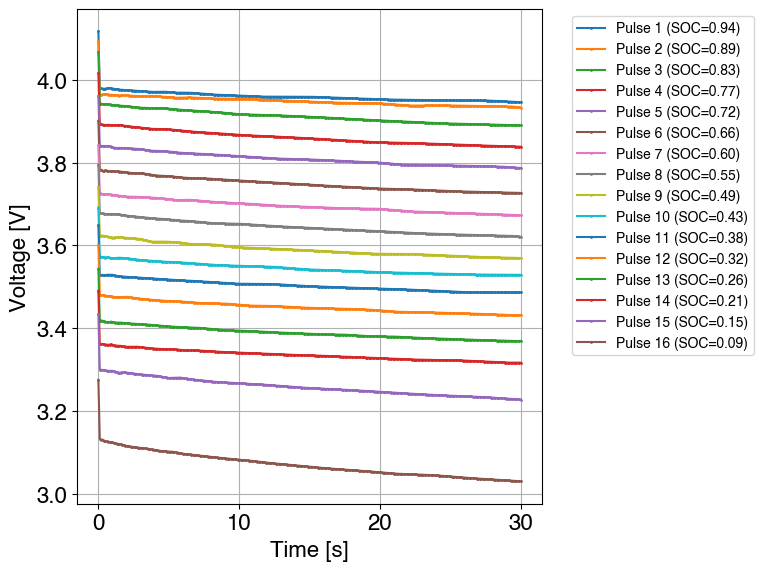

In [ ]:
# Let's try to find the parameters another way. Extract each pulse explicitly and focus on fitting to just the pulse data.
time_s = df_interp['Time [s]']
current_a = df_interp['Current [A]']
voltage_v = df_interp['Voltage [V]']

# Find indices where current transitions from 0A to >4A
pulse_indices = []
for i in range(1, len(current_a)):
    if current_a[i-1] == 0 and current_a[i] > 4:
        pulse_indices.append(i)

# Print time points where pulses occur
print(f"Found {len(pulse_indices)} pulses at following time points (minutes):")

# Initialize lists to store pulse data
pulses_data = []

for idx in pulse_indices:

    # Get data from just before pulse starts
    # Find end of pulse (when current returns to 0)
    start_idx = idx - 1
    end_idx = start_idx + 1

    while end_idx < len(current_a) and current_a[end_idx] > 4:
        end_idx += 1

    # Extract data for this pulse
    pulse_data = {
        'time': time_s[start_idx:end_idx] - time_s[start_idx:end_idx].iloc[0],
        'voltage': voltage_v[start_idx:end_idx],
        'current': current_a[start_idx:end_idx],
        'soc': df_interp['SOC'][start_idx],  # SOC at start of pulse
        'ocv': voltage_v[start_idx],
        'start_idx': start_idx,
        'end_idx': end_idx,
    }
    pulses_data.append(pulse_data)

    # Calculate dt from the time data
    dt = pulse_data['time'].iloc[1] - pulse_data['time'].iloc[0]

    # Fit the pulse data
    rs, r1, c1, cond_num = fit.least_squares(
                            pulse_data['voltage'],
                        -pulse_data['current'],
                        pulse_data['ocv'], dt
                        )

    # Store results in pulse_data
    pulse_data['Rs'] = rs
    pulse_data['R1'] = r1
    pulse_data['C1'] = c1
    pulse_data['condition_number'] = cond_num

    # Print summary
    print(f"t = {time_s[idx]/60:.1f} min, Duration: {pulse_data['time'].iloc[-1] - pulse_data['time'].iloc[0]:.1f} s")

print(f"\nExtracted {len(pulses_data)} pulses")

# Plot all pulses
plt.figure(figsize=(8, 6))
for i, pulse_data in enumerate(pulses_data):
    plt.plot(pulse_data['time'], pulse_data['voltage'], 'o-', markersize=1,
                label=f'Pulse {i+1} (SOC={pulse_data["soc"]:.2f})')

plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()

# Extract data from pulses_data for plotting
soc_vals = np.array([p['soc'] for p in pulses_data])
rs_vals = np.array([p['Rs'] for p in pulses_data])
r1_vals = np.array([p['R1'] for p in pulses_data])
c1_vals = np.array([p['C1'] for p in pulses_data])

plt.savefig('../output/figs/hppc_pulses_only.png', dpi=150)


# Use the simple method to calculate $R_s$

In [51]:
Vmeas = voltage_interp2
Imeas = current_interp2
den = Imeas[0:-2] - Imeas[1:-1]
num = Vmeas[1:-1] - Vmeas[0:-2]
idx = np.where(np.abs(den) > 0.1)[0]
tt = time_s2[idx]
ss = soc_interp2[idx]
R_simple = num[idx]/den[idx]
R_sim_filt = one_pole_digital_filter(R_simple, 0.01)

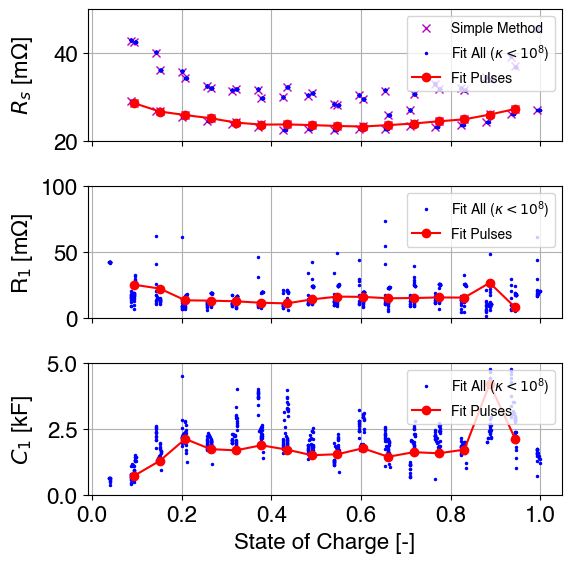

In [55]:
# Plot against SOC
# Create new figure with 5 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
plt.subplots_adjust(hspace=0.2)

msz = 1.5

# Plot filtered Rs
ax1.plot(ss, R_sim_filt*1e3, 'x', c='m', label='Simple Method')
ax1.plot(filtered_soc, filtered_params[:, 0]*1e3, 'o', c='b',
         markersize=msz, label=r'Fit All ($\kappa < 10^8$)')
ax1.plot(soc_vals, rs_vals*1e3, 'o-', c='r', label='Fit Pulses')
ax1.set_ylabel(r'$R_s$ [m$\Omega$]')
ax1.set_ylim((20, 50))
ax1.legend(loc='upper right', fontsize=10)

# Plot filtered R1
ax2.plot(filtered_soc, filtered_params[:, 1]*1e3, 'o', c='b',
         markersize=msz, label=r'Fit All ($\kappa < 10^8$)')
ax2.plot(soc_vals, r1_vals*1e3, 'o-', c='r', label='Fit Pulses')
ax2.set_ylabel(r'R$_1$ [m$\Omega$]')
ax2.set_ylim((0,100))
ax2.legend(loc='upper right', fontsize=10)

# Plot filtered C1
ax3.plot(filtered_soc, filtered_params[:, 2]/1e3, 'o', c='b',
         markersize=msz, label=r'Fit All ($\kappa < 10^8$)')
ax3.plot(soc_vals, c1_vals/1e3, 'o-', c='r', label='Fit Pulses')
ax3.set_ylabel(r'$C_1$ [kF]')
ax3.set_ylim((0,5))
ax3.legend(loc='upper right', fontsize=10)

ax3.set_xlabel('State of Charge [-]')
fig.align_ylabels()

fig.tight_layout()
plt.savefig('../output/figs/hppc_parameter_estimation_2.png', dpi=150)

# Save the processed RC parameters

In [33]:
# Create dataframe from parameters
params_df = pd.DataFrame({
    'SOC': soc_vals[::-1],
    'Rs [Ohm]': rs_vals[::-1],
    'R1 [Ohm]': r1_vals[::-1],
    'C1 [F]': c1_vals[::-1]
})

# Save to CSV file
params_df.to_csv('../output/parameters/rc_parameters.csv', index=False)

In [34]:
params_df

,SOC,Rs [Ohm],R1 [Ohm],C1 [F]
0,0.094896,0.028584,0.025272,743.042703
1,0.151465,0.026715,0.022375,1304.376114
2,0.208034,0.025911,0.013540,2132.313854
3,0.264603,0.025193,0.013258,1745.049794
4,0.321172,0.024201,0.012762,1699.073227
5,0.377741,0.023742,0.011650,1891.884015
6,0.434310,0.023780,0.011193,1726.892616
7,0.490879,0.023634,0.014233,1514.874554
8,0.547448,0.023426,0.016330,1552.178880
9,0.604017,0.023308,0.016111,1777.549822


In [35]:
np.median(params_df['Rs [Ohm]']), np.median(params_df['R1 [Ohm]']), np.median(params_df['C1 [F]'])

(0.02434889377636944, 0.015151729805299748, 1712.2486954682545)